# Import libraries & define constants

In [24]:
from math import sqrt, ceil
import os
from os import listdir
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras import applications, Model

COLAB = False # TODO1 change upper/lower case costant

DATASET_PATH = "../res/dataset/"
MODEL_PARAM_DIR = "../res/model_param/"
LOAD = True
LOAD_MODEL = True

# TODO2 do a better code
if COLAB:
    DATASET_PATH = "/content/ds_unzipped/chest_xray/chest_xray/"
    MODEL_PARAM_DIR = ""
    LOAD = False

PATHS = {"train": DATASET_PATH+"train/", "val": DATASET_PATH+"val/", "test": DATASET_PATH+"test/"}
PATH_LABELS = {"normal": "NORMAL/", "pneumonia": "PNEUMONIA/", "bacteria": "BACTERIA/", "virus": "VIRUS/", }

LABELS = [item.lower() for item in os.listdir(PATHS["train"])]

BATCH_SIZE = 16 # TODO change?

COLOR_MODE = 'rgb'
CLASS_MODE = "binary" #or 'categorical'
RESCALE = 1./255
ROTATION_RANGE = 20
WIDTH_SHIFT_RANGE = 0.2
HEIGHT_SHIFT_RANGE = 0.2
SHEAR_RANGE = 0.15
HORIZONTAL_FLIP = True
FILL_MODE = "nearest"
INPUT_SHAPE = (256, 256, 1)
if tf.keras.backend.image_data_format() == 'channels_first':
    INPUT_SHAPE = (INPUT_SHAPE[-1], INPUT_SHAPE[0], INPUT_SHAPE[1])
INPUT_SHAPE3 = INPUT_SHAPE[0:2]+(3,)
if tf.keras.backend.image_data_format() == 'channels_first':
    INPUT_SHAPE3 = (INPUT_SHAPE3[-1], INPUT_SHAPE3[0], INPUT_SHAPE3[1])

POOL_SIZE = (2,2)
KERNEL_SIZE = (3,3)
ACTIVATION_HIDDEN_LAYERS = 'relu'
ACTIVATION_OUTPUT_LAYER = 'sigmoid' #or 'softmax'
DROPOUT = 0.5
OUTPUT_NEURONS = 1 #or 3

LOSS = 'binary_crossentropy' #or 'categorical_crossentropy'
OPTIMIZER = 'adam'
METRICS = ['accuracy']
EPOCH = 50 # TODO increase
    
WEIGHTS = "imagenet"

LAYERS = 15
LR = 1e-4
MOMENTUM = 0.9

# Load the data

In [4]:
def separate_pneuomia_classes(dir):
    label_dir = {"pneumonia": dir+PATH_LABELS["pneumonia"], "bacteria": dir+PATH_LABELS["bacteria"], "virus": dir+PATH_LABELS["virus"]}
    
    if os.path.exists(label_dir["bacteria"]) or os.path.exists(label_dir["virus"]):
        return
    else:
        os.mkdir(label_dir["bacteria"])
        os.mkdir(label_dir["virus"])
    
    for f in listdir(label_dir["pneumonia"]):
        shutil.move(label_dir["pneumonia"]+f, label_dir["virus"] if "virus" in f else label_dir["bacteria"])
        
    shutil.rmtree(label_dir["pneumonia"])

#separate_pneuomia_classes(PATHS["train"])
#separate_pneuomia_classes(PATHS["val"])
#separate_pneuomia_classes(PATHS["test"])

train_datagen = ImageDataGenerator(rescale=RESCALE, rotation_range=ROTATION_RANGE, width_shift_range=WIDTH_SHIFT_RANGE, height_shift_range=HEIGHT_SHIFT_RANGE, horizontal_flip=HORIZONTAL_FLIP, shear_range=SHEAR_RANGE, fill_mode=FILL_MODE)
test_datagen = ImageDataGenerator(rescale=RESCALE)

train_generator = train_datagen.flow_from_directory(PATHS["train"], target_size = INPUT_SHAPE3[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)
val_generator = test_datagen.flow_from_directory(PATHS["val"], target_size = INPUT_SHAPE3[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)
test_generator = test_datagen.flow_from_directory(PATHS["test"], target_size = INPUT_SHAPE3[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE)

image_count = {"train": len(train_generator.filenames), "val": len(val_generator.filenames), "test": len(test_generator.filenames)}
steps_per_epoch = {"train": np.ceil(image_count["train"]/BATCH_SIZE), "val": np.ceil(image_count["val"]/BATCH_SIZE), "test": np.ceil(image_count["test"]/BATCH_SIZE)}

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Utils

## Show batch

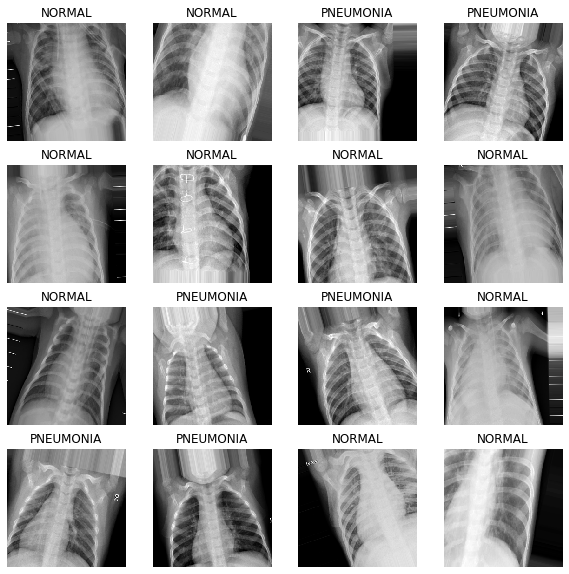

In [23]:
def show_batch(image_batch, label_batch, size):
    figsize = (10,10)
    cmap = "gray"
    axis = "off"
    
    plt.figure(figsize=figsize)
    rows_cols = ceil(sqrt(size))
  
    for n in range(size):
        ax = plt.subplot(rows_cols,rows_cols,n+1)
        plt.imshow(image_batch[n][:,:,0], cmap=cmap)
        #plt.title(LABELS[(label_batch[n]==1).tolist().index(True)])
        plt.title("NORMAL" if label_batch[n]==1 else "PNEUMONIA") #TODO1 check if "0" is "NORMAL" and vice versa #TODO2 better
        plt.axis(axis)
      
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch, BATCH_SIZE)

## Plot learning

In [ ]:
def plot_learning(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.figure()
    
    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')

# Model

## Simple CNN

In [5]:
model = Sequential()

model.add(Conv2D(32, KERNEL_SIZE, input_shape=INPUT_SHAPE3))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Conv2D(32, KERNEL_SIZE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Conv2D(64, KERNEL_SIZE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Flatten()) # converts 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_NEURONS))
model.add(Activation(ACTIVATION_OUTPUT_LAYER))

if LOAD:
    if LOAD_MODEL:    
        model = load_model(MODEL_PARAM_DIR+"simple_model.h5")
    else:
        model.load_weights(MODEL_PARAM_DIR+"simple_weights.h5")
        
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
else:
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    history = model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCH, steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"])
    plot_learning(history)
    
    model.save(MODEL_PARAM_DIR+'simple_model.h5')
    model.save_weights(MODEL_PARAM_DIR+'simple_weights.h5')
    
#predict = model.predict_generator(test_generator, steps = steps_per_epoch["test"])
val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print(val_score)
print(test_score)

Epoch 1/50
  4/326 [..............................] - ETA: 5:38 - loss: 1.5926 - accuracy: 0.7344

KeyboardInterrupt: 

## Transfer learning (VGG16)

### Transfer learning (VGG16) freeze 1

In [9]:
#def gray_to_rgb(img):
#    return np.repeat(img, 3, 2)

#datagen = ImageDataGenerator(rescale=RESCALE, preprocessing_function=gray_to_rgb)

vgg16 = applications.VGG16(weights=WEIGHTS, include_top=False, input_shape=INPUT_SHAPE3)

for layer in vgg16.layers:
    layer.trainable=False
    
# vgg16.summary()

model = Sequential([
    vgg16,
    
    Flatten(),
    Dense(512, activation=ACTIVATION_HIDDEN_LAYERS),
    BatchNormalization(),
    Dropout(DROPOUT),
    
    Dense(64, activation=ACTIVATION_HIDDEN_LAYERS),
    BatchNormalization(),
    Dropout(DROPOUT),
    
    Dense(OUTPUT_NEURONS, activation=ACTIVATION_OUTPUT_LAYER)
])

# model.summary()

# TODO2 Create a function
if LOAD:
    if LOAD_MODEL:    
        model = load_model(MODEL_PARAM_DIR+"model_vgg16_freeze1.h5")
    else:
        model.load_weights(MODEL_PARAM_DIR+"weights_vgg16_freeze1.h5")
        
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
else:
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    history = model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCH, steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"])
    plot_learning(history)
    
    model.save(MODEL_PARAM_DIR+'model_vgg16_freeze1.h5')
    model.save_weights(MODEL_PARAM_DIR+'weights_vgg16_freeze1.h5')
    
val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print(val_score)
print(test_score)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

KeyboardInterrupt: 

### Transfer learning (VGG16) freeze 2

#### Freeze

In [10]:
OPTIMIZER = opt = SGD(lr=LR, momentum=MOMENTUM)
# load the VGG16 network, ensuring the head FC layer sets are left off
base_model = applications.VGG16(weights=WEIGHTS, include_top=False, input_shape=INPUT_SHAPE3)
 
# construct the head of the model that will be placed on top of the the base model
# TODO1 do in the typical way
headModel = base_model.output
headModel = Flatten()(headModel)
headModel = Dense(512, activation=ACTIVATION_HIDDEN_LAYERS)(headModel)
headModel = Dropout(DROPOUT)(headModel)
headModel = Dense(OUTPUT_NEURONS, activation=ACTIVATION_OUTPUT_LAYER)(headModel)
 
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in base_model.layers:
	layer.trainable = False

if LOAD:
    if LOAD_MODEL:    
        model = load_model(MODEL_PARAM_DIR+"model_vgg16_freeze2_before.h5")
    else:
        model.load_weights(MODEL_PARAM_DIR+"weights_vgg16_freeze2_before.h5")
        
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
else:
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    history = model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCH, steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"])
    plot_learning(history)
    
    model.save(MODEL_PARAM_DIR+'model_vgg16_freeze2_before.h5')
    model.save_weights(MODEL_PARAM_DIR+'weights_vgg16_freeze2_before.h5')

val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print(val_score)
print(test_score)

Epoch 1/50
  1/326 [..............................] - ETA: 25:52 - loss: 0.4379 - accuracy: 0.9375

KeyboardInterrupt: 

#### Unfreeze

In [11]:
# reset our data generators
train_generator.reset()
val_generator.reset()
test_generator.reset()
 
# now that the head FC layers have been trained/initialized, lets unfreeze the final set of CONV layers and make them trainable
for layer in base_model.layers[LAYERS:]:
	layer.trainable = True

if LOAD:
    if LOAD_MODEL:    
        model = load_model(MODEL_PARAM_DIR+"model_vgg16_freeze2_after.h5")
    else:
        model.load_weights(MODEL_PARAM_DIR+"weights_vgg16_freeze2_after.h5")
        
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
else:
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    history = model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCH, steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"])
    plot_learning(history)
    
    model.save(MODEL_PARAM_DIR+'model_vgg16_freeze2_after.h5')
    model.save_weights(MODEL_PARAM_DIR+'weights_vgg16_freeze2_after.h5')

val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print(val_score)
print(test_score)

Epoch 1/50
 14/326 [>.............................] - ETA: 29:26 - loss: 0.5124 - accuracy: 0.8080

KeyboardInterrupt: 